## PROJECT TITLE: CUSTOMER CHURN PREDICTION MODEL
## MOTIVATION FOR WORK: 
In today’s highly competitive telecommunications industry, customer retention is more cost-effective than acquiring new ones. Understanding the reasons why customers leave (churn) is essential for sustaining profitability and long-term growth. Companies collect vast amounts of customer data, yet much of it goes underutilized. 
This project is driven by the motivation to transform that raw data into actionable insights using machine learning. By building a predictive model for customer churn, we aim to empower telecom businesses to proactively identify at-risk customers and take strategic actions to retain them. Additionally, applying techniques like SMOTE for balancing data and visual analytics for interpretation ensures that our model is both accurate and explainable. Ultimately, the project blends the power of data science with business impact to solve a real-world problem that directly affects customer satisfaction and revenue.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE

## READING THE DATA
We begin by importing the necessary Python libraries like Pandas, NumPy, Seaborn, and Matplotlib. The dataset WA_Fn-UseC_-Telco-Customer-Churn.csv is then read using pandas.read_csv(). This dataset contains details about customer demographics, services opted, account information, and whether they have churned (i.e., discontinued the service). We drop the customerID column because it is just an identifier and doesn’t carry predictive value.



In [4]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [5]:
print("\nDataset Shape:", df.shape)


Dataset Shape: (7043, 21)


In [6]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## DATA CLEANING AND PREPROCESSING

After loading the data, we focus on cleaning it to ensure consistency and readiness for analysis. We convert the TotalCharges column to a numeric format since it might contain spaces or invalid entries. Using pd.to_numeric() with errors='coerce' ensures such invalid values are turned into NaN. We then replace these missing values with the median of the TotalCharges column using fillna(). This approach ensures that no bias is introduced due to extreme outliers. We also use LabelEncoder to convert categorical string columns into numerical format, making them suitable for machine learning algorithms.



In [9]:
df.drop('customerID', axis=1, inplace=True)

In [10]:
print("\nMissing Values Before Handling:\n", df.isnull().sum())


Missing Values Before Handling:
 gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [11]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

In [12]:
print("\nMissing Values After Handling:\n", df.isnull().sum())


Missing Values After Handling:
 gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [13]:
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

## RUNNING STATISTICS

In [15]:
print("\nSummary Statistics:\n", df.describe())


Summary Statistics:
             gender  SeniorCitizen      Partner   Dependents       tenure  \
count  7043.000000    7043.000000  7043.000000  7043.000000  7043.000000   
mean      0.504756       0.162147     0.483033     0.299588    32.371149   
std       0.500013       0.368612     0.499748     0.458110    24.559481   
min       0.000000       0.000000     0.000000     0.000000     0.000000   
25%       0.000000       0.000000     0.000000     0.000000     9.000000   
50%       1.000000       0.000000     0.000000     0.000000    29.000000   
75%       1.000000       0.000000     1.000000     1.000000    55.000000   
max       1.000000       1.000000     1.000000     1.000000    72.000000   

       PhoneService  MultipleLines  InternetService  OnlineSecurity  \
count   7043.000000    7043.000000      7043.000000     7043.000000   
mean       0.903166       0.940508         0.872923        0.790004   
std        0.295752       0.948554         0.737796        0.859848   
min      

## EXPLORATORY DATA ANALYSIS

Exploratory Data Analysis helps in understanding the structure, patterns, and relationships in the data. We start by checking the dataset shape, types, and summary statistics. Visualizations such as count plots are used to inspect the distribution of the Churn variable, which is the target. Histograms show the distribution of numerical features like tenure, MonthlyCharges, and TotalCharges, helping identify skewness or outliers. Boxplots grouped by Churn offer insights into how these features vary across churned and non-churned customers. We also plot count plots for categorical variables segmented by churn to spot which services, contracts, or demographics affect customer retention. Lastly, a heatmap is generated to show correlations among variables, helping us identify which features may have predictive power.

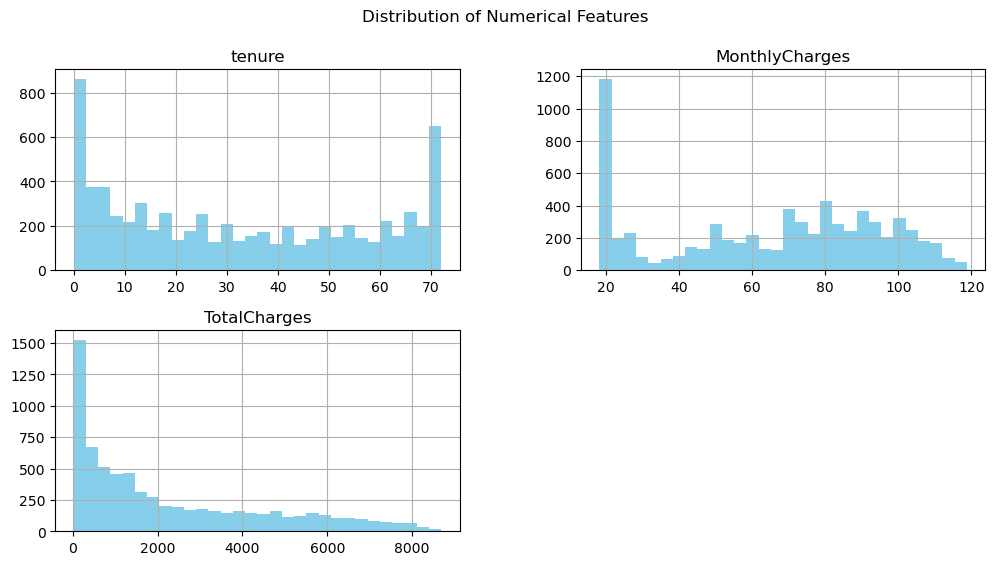

In [17]:
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[num_cols].hist(bins=30, figsize=(12, 6), color='skyblue')
plt.suptitle("Distribution of Numerical Features")
plt.show()

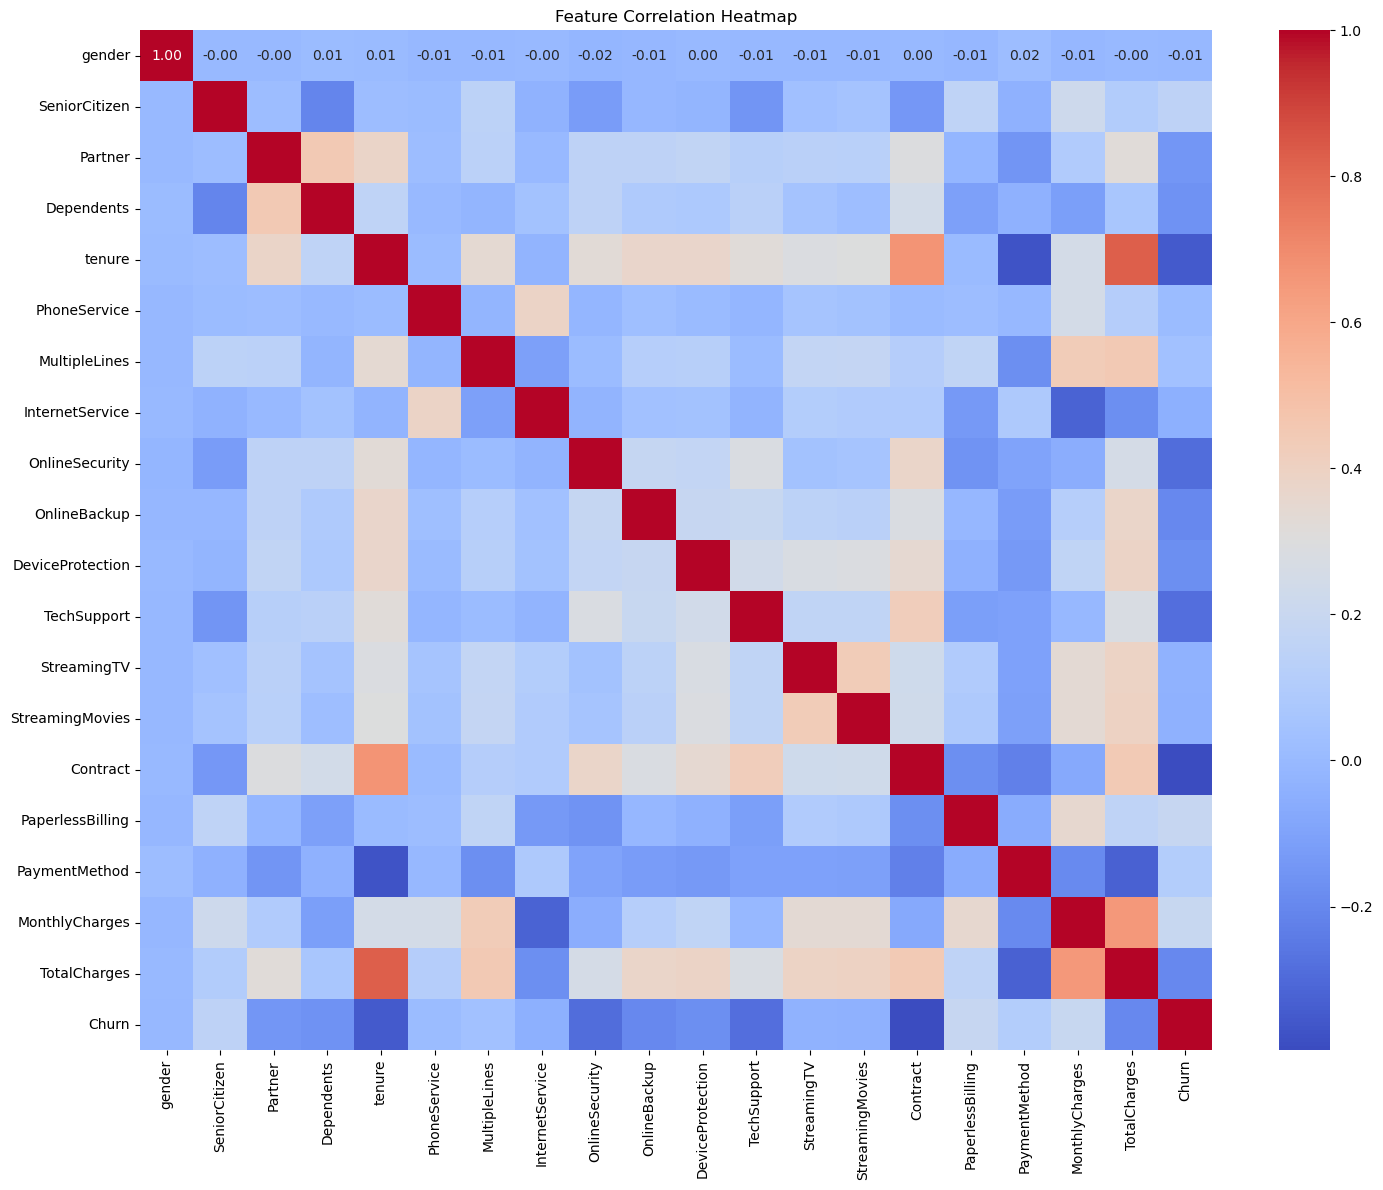

In [18]:
plt.figure(figsize=(15, 12))
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

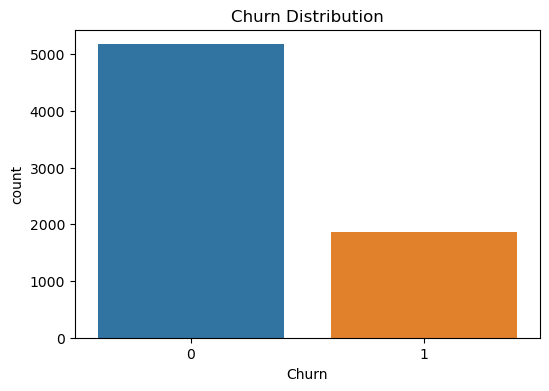

In [19]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.show()

In [21]:
X = df.drop('Churn', axis=1)
y = df['Churn']

## IMBALANCE DATA HANDELING

The Churn variable is typically imbalanced, meaning far fewer customers churn than those who stay. This imbalance can bias machine learning models toward predicting the majority class. To address this, we apply SMOTE (Synthetic Minority Oversampling Technique), which synthetically generates new samples for the minority class (churned customers) based on feature similarity. This creates a balanced dataset where both classes have equal representation, improving the model's ability to learn patterns from churned customers.



In [33]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

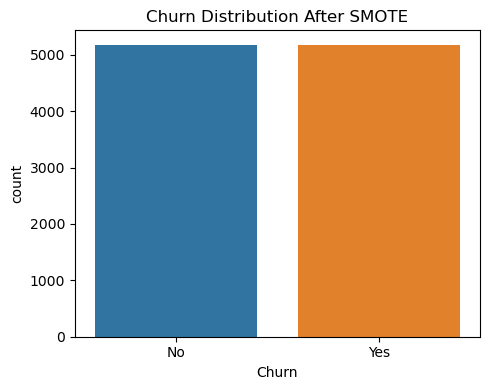

In [34]:
plt.figure(figsize=(5, 4))
sns.countplot(x=y_resampled)
plt.title("Churn Distribution After SMOTE")
plt.xticks([0, 1], ['No', 'Yes'])
plt.tight_layout()
plt.show()

## SCALING

After balancing the data using SMOTE, we apply feature scaling using StandardScaler to ensure all features are on the same scale. This helps improve model performance by preventing features like MonthlyCharges, tenure, and TotalCharges from dominating due to differing ranges. Scaling is done after SMOTE to keep the distribution consistent.

In [36]:
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled_scaled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

## MODEL BUILDING

We then build a Random Forest Classifier, which is a powerful ensemble learning algorithm. It works by creating a multitude of decision trees and aggregating their predictions. This helps in reducing overfitting and improves generalization. We use a version of the model with tuned hyperparameters such as n_estimators, max_depth, min_samples_split, and min_samples_leaf, which help control the tree structure and prevent the model from becoming too complex. The model is trained on the resampled and scaled training set using fit().

In [40]:
rf = RandomForestClassifier(
    n_estimators=200, max_depth=10, min_samples_split=10,
    min_samples_leaf=4, random_state=42, n_jobs=-1
)
rf.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                       n_estimators=200, n_jobs=-1, random_state=42)

In [41]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
y_test_proba = rf.predict_proba(X_test)[:, 1]

## MODEL EVALUATION

Once trained, the model is evaluated using various metrics. Predictions on the training and test sets are obtained and compared using a classification report, which includes precision, recall, f1-score, and support. Accuracy is calculated for quick reference. A confusion matrix is plotted to visualize true positives, true negatives, false positives, and false negatives. We also compute the ROC AUC score to assess the model’s ability to discriminate between churn and non-churn. Finally, we generate a ROC curve to visually analyze the trade-off between the true positive rate and the false positive rate at various threshold settings. Additionally, we plot feature importances to interpret which input features had the most influence on the model’s decisions, helping stakeholders understand key churn indicators.



In [44]:
print("\n--- Training Classification Report ---")
print(classification_report(y_train, y_train_pred))
print("\n--- Testing Classification Report ---")
print(classification_report(y_test, y_test_pred))
print("Testing Accuracy:", accuracy_score(y_test, y_test_pred))


--- Training Classification Report ---
              precision    recall  f1-score   support

           0       0.90      0.85      0.88      4139
           1       0.86      0.91      0.88      4139

    accuracy                           0.88      8278
   macro avg       0.88      0.88      0.88      8278
weighted avg       0.88      0.88      0.88      8278


--- Testing Classification Report ---
              precision    recall  f1-score   support

           0       0.85      0.80      0.82      1035
           1       0.81      0.86      0.83      1035

    accuracy                           0.83      2070
   macro avg       0.83      0.83      0.83      2070
weighted avg       0.83      0.83      0.83      2070

Testing Accuracy: 0.827536231884058


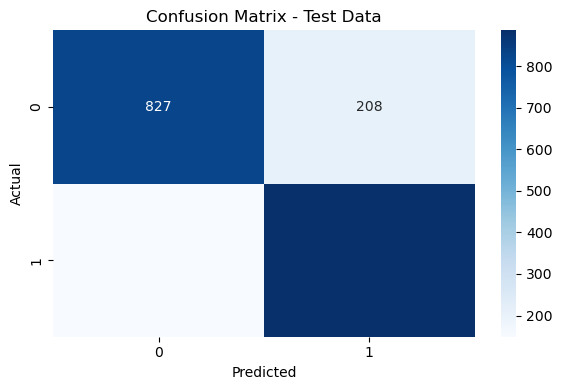

In [47]:
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Test Data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

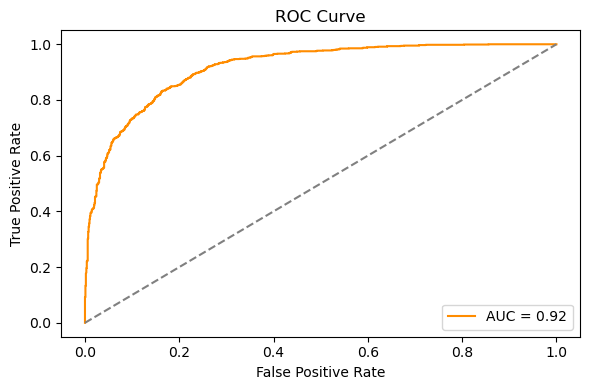

In [48]:
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

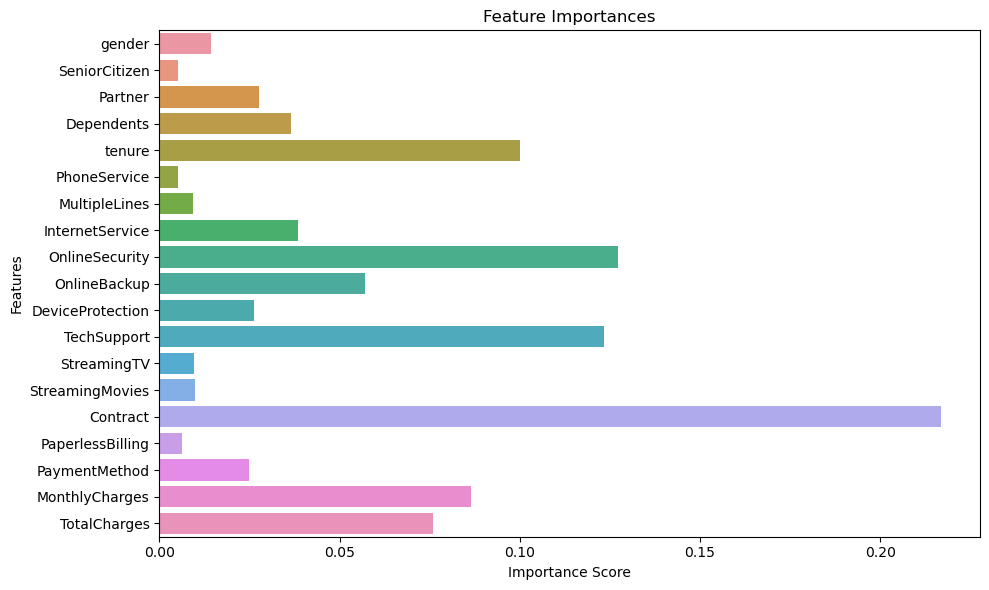

In [50]:
importances = rf.feature_importances_
features = X.columns
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.title("Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()